In [1]:
#pip install mpl_toolkits

In [2]:
import random
import shapely
from shapely import Point
import geopandas
from geopandas import GeoSeries, GeoDataFrame
from geopandas import read_file
from geodatasets import get_path
import pyogrio
from pyogrio import read_dataframe, list_drivers, read_info, write_dataframe
from matplotlib import pyplot

In [3]:
# CONSTANTS

# Google Maps is in a projected coordinate system that is based on the wgs84 datum. (EPSG 3857)
# This projection is in meters, so when setting buffer while in this projection, the units will be meters
# wich is what google uses
# sf.to_crs(3857)
# https://stackoverflow.com/questions/72073417/userwarning-geometry-is-in-a-geographic-crs-results-from-buffer-are-likely-i
PROJECTION_EPSG = 3857
PROJECTION = 'EPSG:' + str(PROJECTION_EPSG)

# Transforming shapely objects (not in dataframes) between projections
# https://gis.stackexchange.com/questions/127427/transforming-shapely-polygon-and-multipolygon-objects

#import pyproj
#from shapely.geometry import Point
#from shapely.ops import transform

#wgs84_pt = Point(-72.2495, 43.886)
#wgs84 = pyproj.CRS('EPSG:4326')
#utm = pyproj.CRS('EPSG:32618')
#project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
#utm_point = transform(project, wgs84_pt)

In [4]:
# Manhattan map background
# 'crs': 'EPSG:2263', 'encoding': 'ISO-8859-1'
manhattanMap = read_dataframe(get_path("nybb"), where="BoroName IN ('Manhattan')").to_crs(PROJECTION)

In [5]:
manhattanMap.centroid

0    POINT (-8233984.803 4979551.765)
dtype: geometry

In [70]:
# Inital condition
STATING_POINT_LAT = 40.776676
STARTING_POINT_LONG = -73.971321

# 750ft is roughly the length of an nyc block (betweem avenues)
# Lets start with a radious of 750 / 2 such that a circle covers at least 1 block
# Later on, experiements will tell whats a good starting size
# Goole maps works distances in meeters, and the limit radius on the nearby search is
# 50,000 meters. https://developers.google.com/maps/documentation/javascript/nearby-search

# Half lenght of a NYC block
RADIUS_METERS = 115

#starting_point_lat  = random.gauss(mu=STATING_POINT_LAT, sigma=0.05)
starting_point_lat  = STATING_POINT_LAT
#starting_point_long = random.gauss(mu=STARTING_POINT_LONG, sigma=0.05)
starting_point_long = STARTING_POINT_LONG

starting_point = Point(starting_point_lat, starting_point_long)

# TODO: fix variance point

starting_point = Point(manhattanMap.centroid.x, manhattanMap.centroid.y)
starting_circle = starting_point.buffer(RADIUS_METERS)

pointsDf = geopandas.GeoDataFrame({'name': ['1']},   
                                  geometry=[starting_point], 
                                  crs=PROJECTION)

second_point = Point(starting_point.x + RADIUS_METERS * 2, starting_point.y)
second_circle = Point(starting_point.x + RADIUS_METERS * 2, starting_point.y).buffer(RADIUS_METERS)


pointSeries = GeoSeries([starting_point, second_point])
circleSeries = geopandas.GeoSeries([starting_point.buffer(RADIUS_METERS), second_point.buffer(RADIUS_METERS)])

pointsArr = [starting_point, second_point]
radiusArr = [RADIUS_METERS, RADIUS_METERS]
circlesArr = [p.buffer(r) for p, r in zip(pointsArr, radiusArr)]

circlesDf = geopandas.GeoDataFrame({'name': ['1', '2'], 
                                   'centroid': pointsArr, 
                                   'radius': radiusArr}, 
                                  geometry=GeoSeries(circlesArr),
                                  crs=PROJECTION)



In [71]:
(starting_point_lat, starting_point_long)

(40.776676, -73.971321)

In [72]:
pointsDf

,name,geometry
0,1,POINT (-8233984.803 4979551.765)


In [73]:
manhattanMap

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-8238858.864 4965915.024, -823..."


In [74]:
circlesDf

,name,centroid,radius,geometry
0,1,POINT (-8233984.803297205 4979551.76476831),115,"POLYGON ((-8233869.803 4979551.765, -8233870.3..."
1,2,POINT (-8233754.803297205 4979551.76476831),115,"POLYGON ((-8233639.803 4979551.765, -8233640.3..."


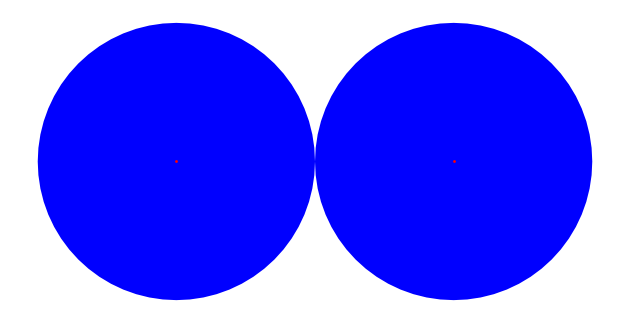

In [77]:
# Plotting
pyplot.close()
#pyplot.figure(figsize=(20, 24))

#minx, miny, maxx, maxy = manhattanMap.total_bounds
#ax.set_xlim(minx, maxx)
#ax.set_ylim(miny, maxy)

base = None
#base = manhattanMap.plot(figsize=(20, 24), alpha=0.5, edgecolor='black', color='lightblue')
#manhattanMap.boundary.plot(ax=ax)
if(base):
    ax = circlesDf.to_crs(PROJECTION).plot(ax=base, markersize=1, color='blue')
else:
    ax = circlesDf.to_crs(PROJECTION).plot( markersize=1, color='blue')
circlesDf.centroid.plot(ax=ax, markersize=1, color='red')
ax.set_axis_off()

# can you print centers from the circles centroids?

# Ensure tight layout
pyplot.tight_layout()

# Display the plot
pyplot.show()

In [ ]:
# Keep adding to the same figure. I may need to research methods for that

# Is the 3rd circle also a special case since the centroid is the same as the point where the 2 circles meet
def compute_tangent_circle_centers_at_angle(centerA, R, angle_degrees):
    """
    Compute the center of a circle of radius R that touches circleA,
    positioned at a specific angle from centerA.
    
    Parameters:
    centerA (Point): The center of circleA
    R (float): The radius of all circles
    angle_degrees (float): The angle in degrees from the positive x-axis
    
    Returns:
    Point: The center of the tangent circle
    """
    x, y = centerA.x, centerA.y
    angle_radians = np.radians(angle_degrees)
    
    # When two circles of the same radius touch externally,
    # their centers are exactly 2*R distance apart
    distance = 2 * R
    
    # Calculate the new center coordinates
    new_x = x + distance * np.cos(angle_radians)
    new_y = y + distance * np.sin(angle_radians)
    
    return Point(new_x, new_y)
